# Data wrangling

This notebook loads the different datasets used in the analysis into a single NETCDF4 file, with descriptive attributes maintained for each dataset. Each dataset is regridded to the ICESat2 grid shape [304, 448] (x,y). The datasets used in this notebook are listed below. The output file is accessible in the [google cloud storage bucket](https://console.cloud.google.com/storage/browser/sea-ice-thickness-data) for this jupyter book and loaded in each notebook. 

## Details on each dataset
Detailed information about each of the datasets used to compile the final data product are provided below in the order they appear in the notebook workflow. The information provided here was last updated 08-21-2021. 

### ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
- **Product Type**: Northern hemisphere gridded monthly means
- **Download link**: 
    - NSIDC (recommended method): https://nsidc.org/data/ATL20
    - Our google storage bucket (provided for compatibility with this Jupyter Book): https://console.cloud.google.com/storage/browser/sea-ice-thickness-data
- **Reference**: Petty, A. A., R. Kwok, M. Bagnardi, A. Ivanoff, N. Kurtz, J. Lee, J. Wimert, and D. Hancock. 2021. ATLAS/ICESat-2 L3B Daily and Monthly Gridded Sea Ice Freeboard, Version 2. Northern hemisphere gridded monthly means. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/ATLAS/ATL20.002. 08-21-2021.

### NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration
- **Variables used**: NOAA/NSIDC sea ice concentration CDR 
- **Download link**: https://nsidc.org/data/g02202
- **Reference**: Meier, W. N., F. Fetterer, A. K. Windnagel, and S. Stewart. 2021. NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. Mean monthly aggregated, northern hemisphere. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center https://doi.org/10.7265/efmz-2t65. 08-21-2021.
- **NOTE**: This is provided as a data variable in the ICESat2 monthly gridded product

### ERA5 monthly averaged data on single levels
- **Variables used**: 2m temperature; Mean surface downward long-wave radiation flux
- **Product type**: Monthly averaged reanalysis 
- **Download link**: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means
- **Reference**: Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2019): ERA5 monthly averaged data on single levels from 1979 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). (Accessed on 16-08-2021), 10.24381/cds.f17050d7

### PIOMAS mean monthly ice thickness
- **Product Type**: Sea ice thickness (Volume per unit Area), monthly mean
- **Variables used**: Sea ice thickness (Volume per unit Area) monthly mean; Grid lon and lat for scalar fields (txt file) 
- **Download link**: http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/data/model_grid
- **Reference**: Zhang, Jinlun and D.A. Rothrock: Modeling global sea ice with a thickness and enthalpy distribution model in generalized curvilinear coordinates, Mon. Wea. Rev. 131(5), 681-697, 2003.
- **NOTE**: You'll want to download the heff format data product, not the text file. For some reason, just clicking on the gzipped file to unzip it raises an error on my computer that the archive is empty (which is not true!). You'll need to unzip the file using the command line; i.e. `gzip -d file.gz`

### Global Low Resolution Sea Ice Drifts from the European Organization for the Exploitation of Meteorological Satellites (EUMETSAT) Ocean and Sea Ice Satellite Application Facility (OSI SAF)
- **Product Type**: Global Low Resolution Sea Ice Drift  
- **Download link**: https://osi-saf.eumetsat.int/products/osi-405-c
- **Reference**: Lavergne, T., Eastwood, S., Teffah, Z., Schyberg, H., and Breivik, L.-A.: Sea ice motion from low-resolution satellite sensors: An alternative method and its validation in the Arctic, J. Geophys. Res., 115, C10032, https://doi.org/10.1029/2009JC005958, 2010.

```{note}
Although you'll see an option to run this notebook in Binder, this notebook is **NOT** configured to run in Binder. If you want to wrangle the data yourself, each dataset used to compile the final data product can be downloaded from the links above. The final data product produced by this notebook can be downloaded from the google storage bucket associated with this jupyter book.
```

# 1) Import notebook dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from datetime import date
import pyproj 
import scipy.interpolate 
from glob import glob
import matplotlib.pyplot as plt
from utils.read_data_utils import read_is2_data # This allows us to read the ICESAT2 data directly from the google storage bucket

# Ignore warnings in the notebook to improve display
import warnings
warnings.filterwarnings('ignore')

# 2) Read in data

## Define filepaths
Define filepaths to data on your local machine

In [2]:
ERA5_path = ''        # ERA5 monthly averaged data on single levels
PIOMAS_path = ''      # PIOMAS mean monthly ice thickness
drift_path = ''       # Polar Pathfinder Daily 25 km EASE-Grid Sea Ice Motion Vectors

In [3]:
#Filepaths on Nicole's computer; cells removed in jupyter book
localDirectory = '../icesat2-book-data/'                         
ERA5_path = localDirectory  + 'ERA5/ERA5_monthly_reanalysis.nc' 
PIOMAS_path = localDirectory + 'PIOMAS/'                         
drifts_path = localDirectory + 'OSI_SAF_drifts/'           

## Set date range of interest
We'll restrict data to this date range, corresponding to years/months in our later analysis

In [4]:
start_date = "Nov 2018"
end_date = "Apr 2021"
date_range = pd.date_range(start=start_date, end=end_date, freq='MS') # MS indicates a time frequency of start of the month
print(date_range)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01'],
              dtype='datetime64[ns]', freq='MS')


## ICESat-2 gridded monthly means

In [8]:
is2_ds = read_is2_data(data_dir="IS2SITMOGR4/v002")

Created directory IS2SITMOGR4/v002


Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201811_005_002.nc...
- [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201812_005_002.nc...
- [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201901_005_002.nc...
- [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                                      
Copying gs://sea-ice-thickness-data/IS2SITMOGR4/v002/IS2SITMOGR4_01_201902_005_002.nc...
- [1/1 files][  9.4 MiB/  9.4 MiB] 100% Done                                    
Operation completed over 1 objects/9.4 MiB.                               

## ERA5 climate reanalysis 

In [9]:
# Read data 
ERA5 = xr.open_dataset(ERA5_path)
ERA5 = ERA5.sel(time = date_range) # Select for date range of interest
ERA5 = ERA5.where(ERA5.latitude > is2_ds.latitude.min()) # Restrict to ICESat-2 latitude
ERA5 = ERA5.sel(expver = 1).drop('expver') # Remove weird variable

# Convert t2m temperature from Kelvin to Celcius 
tempCelcius = ERA5['t2m'] - 283.15
tempCelcius.attrs['units'] = 'C' # Change units attribute to C (Celcius)
tempCelcius.attrs['long_name'] = '2 meter temperature'
ERA5 = ERA5.assign(t2m = tempCelcius) #Add to dataset as a new data variable

# Add descriptive attributes 
ERA5.attrs = {'description': 'era5 monthly averaged data on single levels from 1979 to present', 
              'website': 'https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview', 
              'contact': 'copernicus-support@ecmwf.int',
              'citation': 'Copernicus Climate Change Service (C3S) (2017): ERA5: Fifth generation of ECMWF atmospheric reanalyses of the global climate . Copernicus Climate Change Service Climate Data Store (CDS), July 2020. https://cds.climate.copernicus.eu/cdsapp#!/home'}

## PIOMAS sea ice thickness 

In [10]:
def get_piomas_data(date_range, data_dir): 
    """ Read in a PIOMAS yearly files and convert to an xr.DataArray object 
    
    Args: 
        date_range (pandas DatetimeIndex): date range to grab data for 
        data_dir (str): directory containing data on local drive 
    
    Returns: 
        PIO_da (xr.DataArray): dataset object containing data for input date range
    
    """

    start_year = date_range[0].year
    end_year = date_range[-1].year

    pio_by_yr = []
    for year in range(start_year, end_year+1): 

        # Most recent year may not have a complete year of data
        # We need to reshape the data to match the number of months available, such that the shape of the numpy array is [month, 120, 360]
        i = 1
        while i <= 12: 
            data = open(data_dir + 'heff.H' + str(year), 'rb') 
            try: 
                pio_np = list(np.fromfile(file = data, dtype='f').reshape([i, 120, 360]))
                break
            except: 
                i += 1
        pio_by_yr += (pio_np)
        
    # Get latitude and longitude 
    gridP = np.loadtxt(data_dir + 'grid.dat.txt')
    lonsP = gridP[0:4320, :].flatten()
    lonsP = np.reshape(lonsP, [120,360])
    latsP = gridP[4320:, :].flatten()
    latsP = np.reshape(latsP, [120,360])

    # Load dataList as an xr.DataArray and add descriptive attributes and coordinates
    time = pd.date_range(start = str(start_year), end = str(end_year) + "-" + str(i), freq = 'MS')
    PIOMAS_da = xr.DataArray(pio_by_yr, 
                             dims = ['time','y','x'], 
                             coords = {'time': time, 'longitude': (('y','x'), lonsP), 'latitude': (('y','x'), latsP)}, 
                             attrs = {'units': 'meters', 
                                      'long_name': 'PIOMAS sea ice thickness', 
                                      'data_download': 'http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/data/', 
                                      'download_date': '08-2020',
                                       'citation': 'Zhang, J.L. and D.A. Rothrock, “Modeling global sea ice with a thickness and enthalpy distribution model in generalized curvilinear coordinates“, Mon. Weather Rev., 131, 845-861, 2003'}, 
                             name = "piomas_ice_thickness")
    PIOMAS_da = PIOMAS_da.sel(time = date_range)

    return PIOMAS_da

In [11]:
pio_da = get_piomas_data(date_range=date_range, data_dir=PIOMAS_path)
pio_da = pio_da.sel(time=date_range) # Select for date range of interest
pio_da = pio_da.where(pio_da.latitude > is2_ds.latitude.min()) # Restrict to ICESat-2 latitude 

## OSI-SAF Sea Ice Drifts
First, we read in the data and resample it to produce monthly means. Then, we reproject the data to the ICESat-2 projection (EPSG 3411). 

In [12]:
def get_projected_vectors(fmonthly, proj):
    """ Project osisaf drifts to map projection (x/y pointing in the new map projection coordinates)
    
    Args: 
        fmonthly (xr.Dataset): monthly OSI-SAF vectors 
        proj (str): map projection to use (i.e. pyproj.Proj("+init=EPSG:3411"))
    
    Returns: 
        fmonthly (xr.Dataset): input data reprojected to proj 
    
    """ 
    
    # Transform to map project coordinates (basemap's axes, assume they have unit of m)
    x0, y0=proj(fmonthly.lon, fmonthly.lat)
    x1, y1=proj(fmonthly.lon1, fmonthly.lat1)

    # Normalize drift components to m/s (x1-x0 is already m, so we just divide by 2-days worth of seconds)
    xt=(x1-x0)/(60*60*24*2.)
    yt=(y1-y0)/(60*60*24*2.)
    
    fmonthly['xpts'] = xr.DataArray(x0, dims=['yc', 'xc']) 
    
    fmonthly['ypts'] = xr.DataArray(y0, dims=['yc', 'xc']) 
    
    fmonthly['x_vel'] = xr.DataArray(xt, dims=['time', 'yc', 'xc']) 
    
    fmonthly['y_vel'] = xr.DataArray(yt, dims=['time', 'yc', 'xc']) 
    
    fmonthly['mag_vel'] = xr.DataArray(np.sqrt(xt**2+yt**2), dims=['time', 'yc', 'xc']) 

    fmonthly = fmonthly.drop(['dt0', 'dt1', 'lon1', 'lat1', 'dX', 'dY'])
    
    # Do some filtering as we're getting some weird values in the Canadian Archipelago
    fmonthly = fmonthly.where(fmonthly.mag_vel<1)

    # Add attributes
    fmonthly.x_vel.attrs = {'description':'along-x component of the ice motion', 'units':'cm/s', 'long_name':'sea ice x velocity'}
    fmonthly.y_vel.attrs = {'description':'along-y component of the ice motion', 'units':'cm/s', 'long_name':'sea ice y velocity'}
    fmonthly.mag_vel.attrs = {'long_name': 'drift vector magnitude', 'units':'cm/s'}
    fmonthly.attrs['citation'] = 'Lavergne, T., Eastwood, S., Teffah, Z., Schyberg, H., and Breivik, L.-A.: Sea ice motion from low-resolution satellite sensors: An alternative method and its validation in the Arctic, J. Geophys. Res., 115, C10032, https://doi.org/10.1029/2009JC005958, 2010.'
    
    return fmonthly

In [13]:
# Read in data 
files = [os.path.join(path, name) for path, subdirs, files in os.walk(drifts_path) for name in files if name.endswith('.nc') and "nh" in name]
files_xr = [xr.open_dataset(file) for file in files]
driftsDaily = xr.concat(files_xr, dim='time').sortby("time")

# Resample monthly 
driftsMonthly = driftsDaily.resample(time='MS', keep_attrs = True).mean() 

# Project to CRS of ICeSat-2 grid
monthlyDrifts_proj = get_projected_vectors(fmonthly=driftsMonthly.copy(), proj=pyproj.Proj("+init=EPSG:3411"))

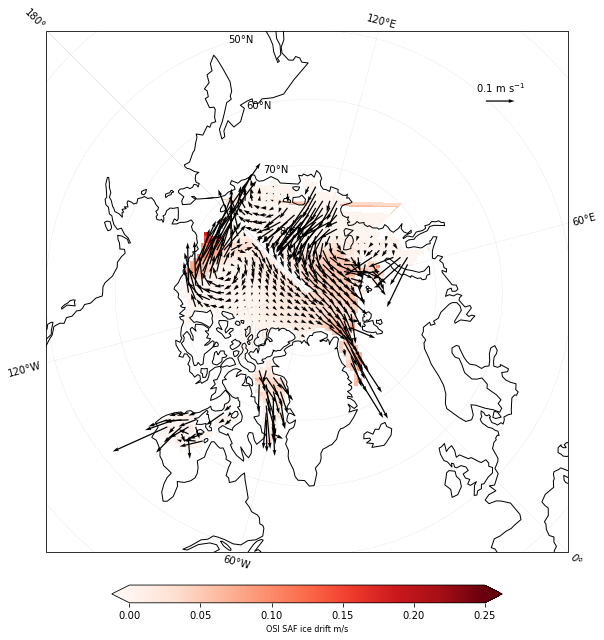

In [38]:
# plot config
import cartopy.crs as ccrs
import matplotlib.colorbar as mcbar
import numpy.ma as ma

minval=0.
maxval=0.25
vector_val=0.1 
scale_vec=0.25
units_lab='m/s'
units_vec=r'm s$^{-1}$'
varStr='OSI SAF ice drift '
# sometimes better to plot every nth number of arrows to reduce clutter
res=2
proj=ccrs.NorthPolarStereo(central_longitude=-45)


fig=plt.figure(figsize=(10, 12))
ax = plt.axes(projection = proj)

cs = ax.pcolormesh(monthlyDrifts_proj.isel(time=2).lon, monthlyDrifts_proj.isel(time=0).lat, 
                   monthlyDrifts_proj.isel(time=2).x_vel, transform=ccrs.PlateCarree(), vmin=minval, vmax=maxval, cmap=plt.cm.Reds, zorder=2)

Q = ax.quiver(monthlyDrifts_proj.isel(time=2).xpts[::res, ::res], monthlyDrifts_proj.isel(time=2).ypts[::res, ::res], 
              ma.masked_where(np.isnan(monthlyDrifts_proj.isel(time=2).x_vel[::res, ::res]), monthlyDrifts_proj.isel(time=2).x_vel[::res, ::res]),
              ma.masked_where(np.isnan(monthlyDrifts_proj.isel(time=2).y_vel[::res, ::res]), monthlyDrifts_proj.isel(time=2).y_vel[::res, ::res]) , units='inches',scale=scale_vec, zorder=5)

ax.coastlines(zorder=3)
ax.gridlines(draw_labels=True,
          linewidth=0.22, color='gray', alpha=0.5, linestyle='--')

#ax.imshow(data, transform=ccrs.PlateCarree(), zorder=2)
# for some reason this extent can freak out if you set 180 to 180
ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())
cax,kw = mcbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
cb=fig.colorbar(cs,cax=cax,extend='both',**kw)
cb.set_label(varStr+units_lab,size=8)

qk = plt.quiverkey(Q, 3389969, 3389969, vector_val, str(vector_val)+' '+units_vec, coordinates='data', zorder = 11)   

plt.show()

# 3) Regrid all datasets to ICESat-2 grid 
In order to merge all the datasets into a singe netcdf4 file, they need to be on the same grid.  

In [14]:
# Initialize map projection and project data to it
out_proj = 'EPSG:3411'
out_lons = is2_ds.longitude.values
out_lats = is2_ds.latitude.values

mapProj = pyproj.Proj("+init=" + out_proj)
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

In [15]:
def regridToICESat2(dataArrayNEW, xptsNEW, yptsNEW, xptsIS2, yptsIS2):  
    """ Regrid new data to ICESat-2 grid 
    
    Args: 
        dataArrayNEW (xarray DataArray): DataArray to be gridded to ICESat-2 grid 
        xptsNEW (numpy array): x-values of dataArrayNEW projected to ICESat-2 map projection 
        yptsNEW (numpy array): y-values of dataArrayNEW projected to ICESat-2 map projection 
        xptsIS2 (numpy array): ICESat-2 longitude projected to ICESat-2 map projection
        yptsIS2 (numpy array): ICESat-2 latitude projected to ICESat-2 map projection
    
    Returns: 
        gridded (numpy array): data regridded to ICESat-2 map projection
    
    """
    gridded = []
    for i in range(len(dataArrayNEW.values)): 
        monthlyGridded = scipy.interpolate.griddata((xptsNEW.flatten(),yptsNEW.flatten()), dataArrayNEW.values[i].flatten(), (xptsIS2, yptsIS2), method = 'nearest')
        gridded.append(monthlyGridded)
    gridded = np.array(gridded)
    return gridded

## ERA5 climate reanalysis

In [16]:
# Choose data variables of interest 
ERA5Vars = ['t2m','msdwlwrf']

#initialize map projection and project data to it
mapProj = pyproj.Proj("+init=" + out_proj)
xptsERA, yptsERA = mapProj(*np.meshgrid(ERA5.longitude.values, ERA5.latitude.values))
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

ERA5_list = []
for var in ERA5Vars: 
    ERA5gridded = regridToICESat2(ERA5[var], xptsERA, yptsERA, xptsIS2, yptsIS2) 
    ERAArray = xr.DataArray(data = ERA5gridded, 
                            dims = ['time', 'y', 'x'], 
                            coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'time':ERA5.time.values}, 
                            name = var)
    ERAArray.attrs = ERA5[var].attrs # Maintain descriptive attributes
    ERAArray = ERAArray.assign_attrs(ERA5.attrs)
    ERA5_list.append(ERAArray)
ERA5_regridded = xr.merge(ERA5_list)

## PIOMAS sea ice thickness 

In [17]:
#project data to ICESat-2 map projection
xptsPIO, yptsPIO = mapProj(pio_da.longitude.values, pio_da.latitude.values)

#regrid data 
pio_regridded = regridToICESat2(pio_da, xptsPIO, yptsPIO, xptsIS2, yptsIS2)
pio_regridded = xr.DataArray(data = pio_regridded, 
                             dims = ['time', 'y', 'x'], 
                             coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), 'time': pio_da.time.values}, 
                             name = pio_da.name)
pio_regridded = pio_regridded.assign_attrs(pio_da.attrs)
pio_regridded = pio_regridded.to_dataset()

## OSI-SAF Sea Ice Drifts

In [33]:
monthlyDrifts_proj

<xarray.Dataset>
Dimensions:                   (time: 32, yc: 177, xc: 119)
Coordinates:
  * xc                        (xc) float64 -3.75e+03 -3.688e+03 ... 3.625e+03
  * yc                        (yc) float64 5.75e+03 5.688e+03 ... -5.25e+03
  * time                      (time) datetime64[ns] 2018-09-01 ... 2021-04-01
    lat                       (yc, xc) float32 31.96 32.2 32.44 ... 35.73 35.47
    lon                       (yc, xc) float32 168.1 167.7 ... -10.84 -10.38
Data variables:
    Polar_Stereographic_Grid  (time, yc, xc) float64 nan nan nan ... nan nan nan
    status_flag               (time, yc, xc) float64 nan nan nan ... nan nan nan
    uncert_dX_and_dY          (time, yc, xc) float32 nan nan nan ... nan nan nan
    xpts                      (yc, xc, time) float64 nan nan nan ... nan nan nan
    ypts                      (yc, xc, time) float64 nan nan nan ... nan nan nan
    x_vel                     (time, yc, xc) float64 nan nan nan ... nan nan nan
    y_vel                     (time, yc, xc) float64 nan nan nan ... nan nan nan
    mag_vel                   (time, yc, xc) float64 nan nan nan ... nan nan nan
Attributes:
    citation:  Lavergne, T., Eastwood, S., Teffah, Z., Schyberg, H., and Brei...

In [18]:
#project data to ICESat-2 map projection
xptsDRIFTS, yptsDRIFTS = mapProj(monthlyDrifts_proj.lon.values, monthlyDrifts_proj.lat.values)

# Loop through variables of interest and regrid 
drifts_list = []
for var in ["x_vel","y_vel"]: 
    driftsGridded = regridToICESat2(monthlyDrifts_proj[var], xptsDRIFTS, yptsDRIFTS, xptsIS2, yptsIS2)

    driftsArray = xr.DataArray(data = driftsGridded, 
                               dims = ['time', 'y', 'x'], 
                               coords = {'latitude': (('y','x'), out_lats), 'longitude': (('y','x'), out_lons), "time": monthlyDrifts_proj.time.values}, 
                               name = var)

    driftsArray.attrs = monthlyDrifts_proj[var].attrs
    driftsArray = driftsArray.assign_attrs(monthlyDrifts_proj.attrs)
    drifts_list.append(driftsArray)

drifts_regridded = xr.merge(drifts_list)

In [30]:
monthlyDrifts_proj.lat.values.shape

(177, 119)

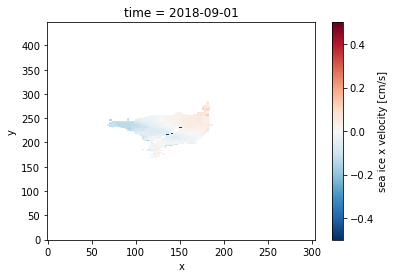

In [26]:
drifts_regridded.x_vel.isel(time=0).plot()

# 4) Compile and save final dataset
Now that all the data is on the same grid, we can use xarray to merge all the datasets.

## Combine datasets

In [20]:
final_ds = xr.merge([is2_ds, pio_regridded, ERA5_regridded, drifts_regridded])
final_ds = final_ds.sel(time=slice("Nov 2018",final_ds.time.values[-1])) # Remove Sep & Oct 2018, which have no data from ICESat-2

## Save data to local machine as a netcdf4 file
We also uploaded this same file to the google storage bucket. 

In [21]:
filename = 'icesat2-book-data.nc'
save_file = True

if (save_file == True):
    try: 
        final_ds.to_netcdf(path=filename, format='NETCDF4', mode='w')
        print('File ' + '"%s"' % filename + ' saved to directory ' + '"%s"' % os.getcwd())
    except: 
        print("Cannot save file because file by same name already exists")

    try: 
        final_ds.to_netcdf(path=localDirectory+filename, format='NETCDF4', mode='w')
        print('File ' + '"%s"' % filename + ' saved to directory "' + '%s' % localDirectory )
    except: 
        print("Cannot save file because file by same name already exists")
else: 
    pass

File "icesat2-book-data.nc" saved to directory "/Users/nicolekeeney/code/icesat2-book"
File "icesat2-book-data.nc" saved to directory "../icesat2-book-data/
